In [1]:
# packages and plot parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
import numpy.ma as ma
import glob
import os
import re
from operator import mul
import sys
import time as time
import h5py
from scipy.io import loadmat
from scipy.io import savemat

plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add helper functions to path
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions/") # go to parent dir
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *

### This script is based on the indices and code from below:
there is a function to define the basins generally which An has a function for
This is found at /home/atnguyen/matlab_mnt_nansen/HelenPillar_layers/lookat_layers_aste.m 
on line 147

### Some MATLAB to Python tips
read_float32(filename) = readbin
parsemeta(filename) = only read .meta with fields
rdmds(filename, time) = read .data file

#### Some tips on definitions
setTS_Ttend = definitions should be in data.diagnostics - check!

### Setting up files, bounds, faces

In [2]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = dirroot + "run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = dirrun + "diags/"

In [3]:
# this was to look at bytes with ls -ltr
# 1172912/146614

In [4]:
# reading in the TH and SLT bins
# read in the original array we fed
boundsT = rdmds(dirrun + "layers2TH", -1)
boundsT = boundsT[:,:,0].flatten()
nT = boundsT.shape[0]-1

boundsS = rdmds(dirrun + "layers1SLT", -1)
boundsS = boundsS[:,:,0].flatten()
nS = boundsS.shape[0]-1

binwidthT = boundsT[1:] - boundsT[:-1]   # this is real width delta
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = (boundsT[:-1] + boundsT[1:])/2
binmidS = (boundsS[:-1] + boundsS[1:])/2

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

In [5]:
bigaste = True    # set up something to trigger in case we run with either big or little

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [6]:
mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

In [7]:
# 126-130
xc = mygrid['XC']
yc = mygrid['YC']
rac = mygrid['RAC']
drf = mygrid['DRF']

In [8]:
d = rdmds(dirgrid + "Depth",-1)
d = np.reshape(d,(ny,nx))
class structtype():
    pass
fld = d
print(fld.shape)

dep =  get_aste_faces (d,nfx,nfy)

(1350, 270)
nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


In [9]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)
# hf1 = hf1[np.newaxis,:, :]
hf1.shape

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

hf1 (1350, 270)
SZ! (1, 900, 540)
shape of fld: (1, 900, 540)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270) (1, 1350, 270)


In [10]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

# 3d
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023
RAC2d (146614,)


### The following is from a previous run

In [11]:
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (yc > latNA) & (xc > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1

In [12]:
# hf can only be deleted after these variables are created!!
# mskBasin3d = np. tile mskBasin (1,1,nz) * hf 
# indBasin 

# An lines 184-96

In [13]:
del hfflat, hf

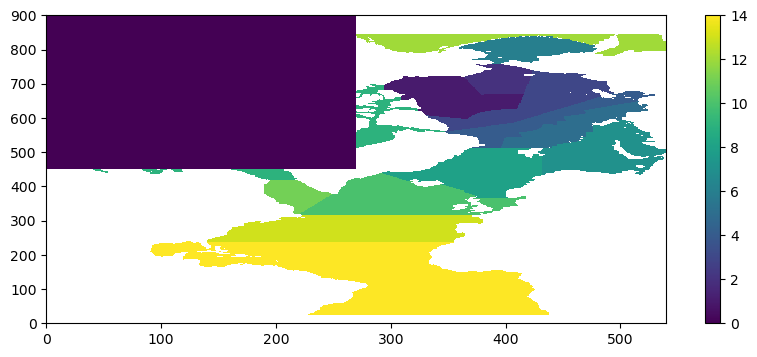

In [14]:
# SOMETHING IS CHANGING WHEN WE CHANGE THE TYPE, IN PCOLORMESH
ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

In [15]:
# this might not be right but we need to see
ind2d = mskBasin.reshape(364500)
ind2d.shape

(364500,)

### Now try to define the gateways

The following code might be helpful: /home/atnguyen/matlab_mnt_nansen/HelenPillar_layers/layers_gateway_exchange_atn.m

In [105]:
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    print(num,label)
    num += 1

1 ['FramStrait']
2 ['NaresStrait']
3 ['CAA']
4 ['BarrowStrait/LancasterSound']
5 ['BarentsSeaOpening']
6 ['Svalbard-FranzJosefIslands']
7 ['FranzJosefIslands-NovayaZemlya']
8 ['KaraStrait']
9 ['StAnnaTrough/Voronin/Vilkitshogo']
10 ['BeringStrait']
11 ['DenmarkStrait']
12 ['Iceland-FaroeI']
13 ['Faroe-Shetland']
14 ['GibraltarStrait']
15 ['DavisStrait']
16 ['FloridaStrait']
17 ['BeringSea']
18 ['SubPolarGyre']
19 ['LabradorSea']

1 ['NansenAmundsen']
2 ['AmundsenMakarov']
3 ['MakarovCBCK']
4 ['FramStraitNansen']
5 ['FramStraitAmundsen']
6 ['NaresStraitMakarov']
7 ['OSNAPeast']


In [106]:
# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

In [107]:
ggate2[0][0][0][0][0][0]
ggate2[0][0][0][0][1][0]
ggate2[0][0][0][0][2][0]
ggate2[0][0][0][0][3][0]
ggate2[0][0][0][0][4][0]

'NansenAmundsen'

In [123]:
gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

In [84]:
# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

In [125]:
# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

### Define basins in all points, then wet points

In [16]:
# create the basins based on the values and make subplots
#        1           2          3           4         5         6        7         8      9     10    11       12      13         14
#strb={'CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA','SPG','LabSea','NPac','NAtlantic','AtlS30'};
idxs = np.arange(0,14,1)
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

# REDEFINE THESE AND REPLACE STRI with similar phrasing for wet indices
iCanada2D = np.where(ind2d == 1)[0]
iChukchiS2D = np.where(ind2d == 2)[0]
iMakarovB2D = np.where(ind2d == 3)[0]
iAmundsenB2D = np.where(ind2d == 4)[0]
iNansenB2D = np.where(ind2d == 5)[0]
iBeringS2D = np.where(ind2d == 6)[0]
iBarentsS2D = np.where(ind2d == 7)[0]
iGINs2D = np.where(ind2d == 8)[0]
iCAA2D = np.where(ind2d == 9)[0]
iSPG2D = np.where(ind2d == 10)[0]
iLabSea2D = np.where(ind2d == 11)[0]
iNPac2D = np.where(ind2d == 12)[0]
iNAtlantic2D = np.where(ind2d == 13)[0]
iAtlS302D = np.where(ind2d == 14)[0]


stri = np.array([iCanada2D,iChukchiS2D,iMakarovB2D,iAmundsenB2D,iNansenB2D,iBeringS2D,iBarentsS2D,iGINs2D,iCAA2D,
                iSPG2D,iLabSea2D,iNPac2D,iNAtlantic2D,iAtlS302D],dtype = "object")

# make subplots based on these - hope we did this right
# myzero = np.zeros((ny*nx))
# fig,axs = plt.subplots(len(stri),figsize = (2,12))
# for i in idxs:
#     myzerotmp = myzero.copy() # copy for reference in loop
#     myzerotmp[stri[i]] = 1
#     myzerotmp =  np.reshape(myzerotmp,(ny,nx))
#     myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
#     axs[i].pcolormesh(myzerotmp[0,:,:])